# Module 1 Final Project

In this notebook I created a database from IMDBs top 1000 movies,
used the OMDB API to scrape other pieces of useful data,
imported and implemented a sql library to manipulate the data,
and created tables to use for my data visualization. 

Towards the bottom of the notebook I created some visualizations of the data. 


### I start by scraping IMDB for titles 

In [1]:
# import necessary libraries 
import requests
from bs4 import BeautifulSoup
import json
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# connect to the website and make a loop to go through the URLs of the different movies
# start_url is a basic url which will be looped through and formatted with a page number
start_url = 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start={}&ref_=adv_nxt'
urls = []
for page in range(1, 1001, 100):
    url = start_url.format(str(page))
    urls.append(url)
urls
# this loop returns the pages for the top 1000 movies 

['https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=1&ref_=adv_nxt',
 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=101&ref_=adv_nxt',
 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=201&ref_=adv_nxt',
 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=301&ref_=adv_nxt',
 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=401&ref_=adv_nxt',
 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=501&ref_=adv_nxt',
 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=601&ref_=adv_nxt',
 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start=701&ref_=adv_nxt',
 'https://www.imdb.com/sea

### Defining necessary functions to scrape titles

In [3]:
# This function gets the page
def get_page(url):
    page = requests.get(url)
    return page

# this function turns the page into html
def make_soup(page):
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup

# selects movies on the page
def select_movies(soup):
    movie_titles = soup.select('div.col-title a')
    return movie_titles

# isolates the title from the html
def get_titles(movie_titles):
    titles = []
    for title in movie_titles:
        titles.append(title.text)
    return titles

# now we'll put all the functions together to loop through the URLs that we want to scrape

title_list = [] # create an empty list to populate with the titles

for url in urls:
    page = get_page(url)
    soup = make_soup(page)
    movie_titles = select_movies(soup)
    titles = get_titles(movie_titles)
    title_list.extend(titles) # use extend over append as appending only adds a single element to a list

title_list

['The Shawshank Redemption',
 'The Godfather',
 'The Dark Knight',
 'The Godfather: Part II',
 'The Lord of the Rings: The Return of the King',
 'Pulp Fiction',
 "Schindler's List",
 '12 Angry Men',
 'Inception',
 'Fight Club',
 'The Lord of the Rings: The Fellowship of the Ring',
 'Forrest Gump',
 'The Good, the Bad and the Ugly',
 'The Lord of the Rings: The Two Towers',
 'The Matrix',
 'Goodfellas',
 'Star Wars: Episode V - The Empire Strikes Back',
 "One Flew Over the Cuckoo's Nest",
 'Harakiri',
 'Parasite',
 'Interstellar',
 'City of God',
 'Spirited Away',
 'Saving Private Ryan',
 'The Green Mile',
 'Life Is Beautiful',
 'Se7en',
 'The Silence of the Lambs',
 'Star Wars: Episode IV - A New Hope',
 'Seven Samurai',
 "It's a Wonderful Life",
 'Joker',
 'Ayla: The Daughter of War',
 'Avengers: Infinity War',
 'Whiplash',
 'The Intouchables',
 'The Prestige',
 'The Departed',
 'The Pianist',
 'Gladiator',
 'American History X',
 'The Usual Suspects',
 'Léon: The Professional',
 'The

### Using the OMDb API to scrape useful movie data
Below I created a for loop to take the titles from the scraped title_list from IMDB then make OMDb API calls to get other information about the movies(genre, director, rating, etc).

In [4]:
# declare my api url as a variable for ease of use
omdb_api_url = "http://www.omdbapi.com/?apikey=fbdae8b7&"

# make api requests by the title parameter as opposed to the IMDb ID
api_titles = []
for title in title_list:
    api_titles.append({'t' : title})
    
# define a function to make the API calls
def api_call(movie_params):
    response = requests.get(omdb_api_url, params=movie_params)
    movie_data = response.json()
    return movie_data

In [5]:
# test API call. Wasn't working with initial API key, 
# had to become a Patron and get another key and it worked.
api_call(api_titles[0])

{'Title': 'The Shawshank Redemption',
 'Year': '1994',
 'Rated': 'R',
 'Released': '14 Oct 1994',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Director': 'Frank Darabont',
 'Writer': 'Stephen King (short story "Rita Hayworth and Shawshank Redemption"), Frank Darabont (screenplay)',
 'Actors': 'Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler',
 'Plot': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Language': 'English',
 'Country': 'USA',
 'Awards': 'Nominated for 7 Oscars. Another 21 wins & 35 nominations.',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '9.3/10'},
  {'Source': 'Rotten Tomatoes', 'Value': '90%'},
  {'Source': 'Metacritic', 'Value': '80/100'}],
 'Metascore': '80',
 'imdbRating': '9.3',
 'imdbVotes': '2,217,195',
 'imdbID': 'tt011116

In [6]:
# borrowed this function from Wetpaint3's github, I was having an issue where my 
# for loop in the cell below was iterating through the data and encountered a blank. 
# It would cause the loop to abort - this function below has cases built into it to
# deal with the missing values that were causing me trouble. 

def parse_movie_data(movie_data):
    parsed_movie_data = []
    for data in movie_data:
        if 'Title' not in data.keys():
            data.setdefault('Title', None)
        if 'Genre' not in data.keys():
            data.setdefault('Genre', None)
        if 'Director' not in data.keys():
            data.setdefault('Director', None)
        if 'Actors' not in data.keys():
            data.setdefault('Actors', None)
        if 'Metascore' not in data.keys():
            data.setdefault('Metascore', None)
        if 'imdbRating' not in data.keys():
            data.setdefault('imdbRating', None)
        if 'imdbID' not in data.keys():
            data.setdefault('imdbID', None)
        if 'Production' not in data.keys():
            data.setdefault('Production', None)
        mov_tuple = (data['Title'], data['Genre'], data['Director'], data['Actors'], data['Metascore'], data['imdbRating'], data['imdbID'], data['Production'])
        parsed_movie_data.append(mov_tuple)
    return parsed_movie_data

In [7]:
# create a for loop to iterate through titles in API calls and return the desired data
agg_movie_data = []
for title in api_titles:
    movie_data = api_call(title)
    agg_movie_data.append(movie_data)
    parsed_movie_data = parse_movie_data(agg_movie_data)

In [8]:
agg_movie_data

[{'Title': 'The Shawshank Redemption',
  'Year': '1994',
  'Rated': 'R',
  'Released': '14 Oct 1994',
  'Runtime': '142 min',
  'Genre': 'Drama',
  'Director': 'Frank Darabont',
  'Writer': 'Stephen King (short story "Rita Hayworth and Shawshank Redemption"), Frank Darabont (screenplay)',
  'Actors': 'Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler',
  'Plot': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
  'Language': 'English',
  'Country': 'USA',
  'Awards': 'Nominated for 7 Oscars. Another 21 wins & 35 nominations.',
  'Poster': 'https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_SX300.jpg',
  'Ratings': [{'Source': 'Internet Movie Database', 'Value': '9.3/10'},
   {'Source': 'Rotten Tomatoes', 'Value': '90%'},
   {'Source': 'Metacritic', 'Value': '80/100'}],
  'Metascore': '80',
  'imdbRating': '9.3',
  'imdbVotes': '2,217,195',


In [9]:
# create a pandas DataFrame from the list of dictionaries
moviedata_df = pd.DataFrame(agg_movie_data)

In [10]:
# preview the DataFrame to ensure it all worked
moviedata_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Error,totalSeasons
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,...,"2,217,195",tt0111161,movie,27 Jan 1998,N/A,Columbia Pictures,N/A,True,NaN,NaN
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay by), Francis Ford Coppo...","Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...,...,"1,532,092",tt0068646,movie,09 Oct 2001,N/A,Paramount Pictures,N/A,True,NaN,NaN
2,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama, Thriller",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker wreaks havo...,...,"2,184,673",tt0468569,movie,09 Dec 2008,"$533,316,061",Warner Bros. Pictures/Legendary,N/A,True,NaN,NaN
3,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay by), Mario Pu...","Al Pacino, Robert Duvall, Diane Keaton, Robert...",The early life and career of Vito Corleone in ...,...,"1,072,495",tt0071562,movie,24 May 2005,N/A,Paramount Pictures,N/A,True,NaN,NaN
4,The Lord of the Rings: The Return of the King,2003,PG-13,17 Dec 2003,201 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay...","Noel Appleby, Ali Astin, Sean Astin, David Aston",Gandalf and Aragorn lead the World of Men agai...,...,"1,576,026",tt0167260,movie,25 May 2004,"$364,000,000",New Line Cinema,N/A,True,NaN,NaN


### Now that I have my scraped data converted into a Pandas DataFrame, it's time for cleaning.
In the below cells I explore my DataFrame, seeking missing values or other errors which could skew my analysis. 

In [11]:
# remove the columns I don't need for my analysis to tidy up the DF a bit
del moviedata_df['Actors']
del moviedata_df['Plot']
del moviedata_df['imdbVotes']
del moviedata_df['DVD']
del moviedata_df['Website']
del moviedata_df['Response']
del moviedata_df['Error']
del moviedata_df['totalSeasons']
del moviedata_df['Poster']

In [12]:
moviedata_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Ratings,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...",English,USA,Nominated for 7 Oscars. Another 21 wins & 35 n...,"[{'Source': 'Internet Movie Database', 'Value'...",80,9.3,tt0111161,movie,N/A,Columbia Pictures
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay by), Francis Ford Coppo...","English, Italian, Latin",USA,Won 3 Oscars. Another 26 wins & 30 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",100,9.2,tt0068646,movie,N/A,Paramount Pictures
2,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama, Thriller",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","English, Mandarin","USA, UK",Won 2 Oscars. Another 153 wins & 159 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",84,9.0,tt0468569,movie,"$533,316,061",Warner Bros. Pictures/Legendary
3,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay by), Mario Pu...","English, Italian, Spanish, Latin, Sicilian",USA,Won 6 Oscars. Another 11 wins & 20 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",90,9.0,tt0071562,movie,N/A,Paramount Pictures
4,The Lord of the Rings: The Return of the King,2003,PG-13,17 Dec 2003,201 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay...","English, Quenya, Old English, Sindarin","New Zealand, USA",Won 11 Oscars. Another 199 wins & 122 nominati...,"[{'Source': 'Internet Movie Database', 'Value'...",94,8.9,tt0167260,movie,"$364,000,000",New Line Cinema


In [13]:
# preview again to ensure it all worked
moviedata_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Ratings,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...",English,USA,Nominated for 7 Oscars. Another 21 wins & 35 n...,"[{'Source': 'Internet Movie Database', 'Value'...",80,9.3,tt0111161,movie,N/A,Columbia Pictures
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay by), Francis Ford Coppo...","English, Italian, Latin",USA,Won 3 Oscars. Another 26 wins & 30 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",100,9.2,tt0068646,movie,N/A,Paramount Pictures
2,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama, Thriller",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","English, Mandarin","USA, UK",Won 2 Oscars. Another 153 wins & 159 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",84,9.0,tt0468569,movie,"$533,316,061",Warner Bros. Pictures/Legendary
3,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay by), Mario Pu...","English, Italian, Spanish, Latin, Sicilian",USA,Won 6 Oscars. Another 11 wins & 20 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",90,9.0,tt0071562,movie,N/A,Paramount Pictures
4,The Lord of the Rings: The Return of the King,2003,PG-13,17 Dec 2003,201 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay...","English, Quenya, Old English, Sindarin","New Zealand, USA",Won 11 Oscars. Another 199 wins & 122 nominati...,"[{'Source': 'Internet Movie Database', 'Value'...",94,8.9,tt0167260,movie,"$364,000,000",New Line Cinema


In [14]:
# look at the shape to double check it's still 1000 movies 
moviedata_df.shape

(1000, 18)

In [15]:
# save this df to csv for future use
moviedata_df.to_csv('Data/zippedData/cleanedOMDbScrape.csv')

In [16]:
# look at where I'm missing values
moviedata_df.isna().sum()

Title         18
Year          18
Rated         18
Released      18
Runtime       18
Genre         18
Director      18
Writer        18
Language      18
Country       18
Awards        18
Ratings       18
Metascore     18
imdbRating    18
imdbID        18
Type          18
BoxOffice     21
Production    21
dtype: int64

In [17]:
# create a table to see what my missing values look like
null_data = moviedata_df[moviedata_df.isnull().any(axis=1)]
null_data

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Ratings,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
54,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
64,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
87,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
136,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
196,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
197,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
202,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
227,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
241,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None
243,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,None


In [18]:
# since it's a small number of rows that are missing all their data, 
# I'm opting to remove those rows entirely and then I'll work with 
# the three other instances. 
moviedata_df = moviedata_df[~moviedata_df['Title'].isnull()]

In [19]:
# check to see if that removal worked as intended
moviedata_df.isna().sum()

Title         0
Year          0
Rated         0
Released      0
Runtime       0
Genre         0
Director      0
Writer        0
Language      0
Country       0
Awards        0
Ratings       0
Metascore     0
imdbRating    0
imdbID        0
Type          0
BoxOffice     3
Production    3
dtype: int64

In [20]:
# look at the null data table to see what else needs to be cleaned up
null_data = moviedata_df[moviedata_df.isnull().any(axis=1)]
null_data

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Ratings,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
431,The Killing,2011–2014,TV-14,03 Apr 2011,45 min,"Crime, Drama, Mystery, Thriller",N/A,Veena Sud,English,"USA, Canada",Nominated for 1 Golden Globe. Another 3 wins &...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.2,tt1637727,series,NaN,None
541,Spartacus,2010–2013,TV-MA,22 Jan 2010,55 min,"Action, Adventure, Biography, Drama, History, ...",N/A,Steven S. DeKnight,"English, German",USA,4 wins & 16 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.5,tt1442449,series,NaN,None
603,Toki o kakeru shôjo,1994–,N/A,19 Feb 1994,54 min,Sci-Fi,N/A,N/A,Japanese,Japan,N/A,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.3,tt1360089,series,NaN,None


In [21]:
# these are apparantly the only series in the DF...As to not influence the other data,
# which is comprised of movies I'm going to remove these rows. 
moviedata_df.Type.value_counts()

movie     979
series      3
Name: Type, dtype: int64

In [22]:
# removing the three rows with missing Production Budget data
moviedata_df = moviedata_df[~moviedata_df['Production'].isnull()]
moviedata_df.isna().sum()
# checked to ensure it worked, it did. No more missing data

Title         0
Year          0
Rated         0
Released      0
Runtime       0
Genre         0
Director      0
Writer        0
Language      0
Country       0
Awards        0
Ratings       0
Metascore     0
imdbRating    0
imdbID        0
Type          0
BoxOffice     0
Production    0
dtype: int64

In [23]:
# save this df to csv for a backup / future use.
moviedata_df.to_csv('Data/zippedData/cleanedOMDbScrape.csv')

In [24]:
# convert imdbRating column to floats from string while turning errors into NaN
moviedata_df['imdbRating'] = pd.to_numeric(moviedata_df['imdbRating'], errors='coerce')

In [25]:
# creating a grouped df with maturity ratings and their imdbRatings
ratings_df = moviedata_df.groupby('Rated').agg({'imdbRating': ['mean', 'min', 'max']})
ratings_df

imdbRating          
                mean  min  max
Rated                         
Approved    8.209091  7.9  8.9
G           7.939535  7.6  8.5
GP          7.925000  7.6  8.1
N/A         7.800000  6.6  8.5
NC-17       7.700000  7.7  7.7
Not Rated   8.020809  7.6  8.7
PG          7.925899  7.4  8.7
PG-13       7.834320  5.5  9.0
Passed      8.008696  7.6  8.4
R           7.908040  6.2  9.3
TV-MA       8.050000  7.8  8.3
TV-PG       7.600000  7.6  7.6
Unrated     7.650000  7.6  7.7

In [26]:
# checking to see if there are any outliers or mistyped data
moviedata_df['imdbRating'].value_counts()

7.7    142
8.0    140
7.6    138
7.8    137
8.1    114
7.9     99
8.2     65
8.3     43
8.4     25
8.5     23
8.6     12
8.7      6
8.8      5
8.9      4
6.6      3
7.3      3
7.4      2
6.2      2
7.5      2
9.0      2
6.9      1
5.7      1
9.3      1
9.2      1
6.3      1
6.5      1
5.5      1
7.2      1
Name: imdbRating, dtype: int64

In [27]:
# looking at the different types of Genre data.
moviedata_df['Genre'].value_counts()

Drama                                                             84
Comedy, Drama                                                     39
Drama, Romance                                                    37
Comedy, Drama, Romance                                            30
Crime, Drama, Thriller                                            29
                                                                  ..
Adventure, Family, Fantasy, Musical                                1
Animation, Adventure, Drama, Family, Fantasy, Sci-Fi, Thriller     1
Drama, Mystery, Sci-Fi                                             1
Action, Crime, Drama, Music, Thriller                              1
Comedy, Drama, Family, Fantasy, Musical                            1
Name: Genre, Length: 335, dtype: int64

## Cleaning up rating and financials
I need to clean up some of the oddities in the Ratings data. In addition to that, the financial data is not stored in a way that I can use numerical operators on them so I need to convert that to floats or ints. Once I've cleaned this bit up, I can move onto the genre splitting and start categorizing and modeling the data. 

In [28]:
# Need to clean up the Rated column to get cleaner data
moviedata_df['Rated'].value_counts()

R            398
Not Rated    173
PG-13        169
PG           139
G             43
Passed        23
N/A           13
Approved      11
GP             4
Unrated        2
TV-MA          2
TV-PG          1
NC-17          1
Name: Rated, dtype: int64

In [29]:
# create a df of all missing data by searching for all rows that contain 'ed'
# which accounts for "Not Rated", "Passed", "Approved", and "Unrated"
nullrating_df = moviedata_df[moviedata_df['Rated'].str.contains('ed')]
nullrating_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Ratings,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
7,12 Angry Men,1957,Approved,10 Apr 1957,96 min,Drama,Sidney Lumet,"Reginald Rose (story), Reginald Rose (screenplay)",English,USA,Nominated for 3 Oscars. Another 16 wins & 9 no...,"[{'Source': 'Internet Movie Database', 'Value'...",96,8.9,tt0050083,movie,N/A,Criterion Collection
18,Harakiri,1962,Not Rated,04 Aug 1964,133 min,"Action, Drama, History",Masaki Kobayashi,"Yasuhiko Takiguchi (novel), Shinobu Hashimoto ...",Japanese,Japan,8 wins & 2 nominations.,"[{'Source': 'Internet Movie Database', 'Value'...",85,8.7,tt0056058,movie,N/A,Criterion Collection
29,Seven Samurai,1954,Not Rated,19 Nov 1956,207 min,"Action, Adventure, Drama",Akira Kurosawa,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",Japanese,Japan,Nominated for 2 Oscars. Another 5 wins & 6 nom...,"[{'Source': 'Internet Movie Database', 'Value'...",98,8.6,tt0047478,movie,N/A,Columbia Pictures
30,It's a Wonderful Life,1946,Not Rated,07 Jan 1947,130 min,"Drama, Family, Fantasy",Frank Capra,"Frances Goodrich (screenplay), Albert Hackett ...","English, French",USA,Nominated for 5 Oscars. Another 6 wins & 1 nom...,"[{'Source': 'Internet Movie Database', 'Value'...",89,8.6,tt0038650,movie,N/A,Liberty Films
46,Grave of the Fireflies,1988,Not Rated,26 Jul 1989,89 min,"Animation, Drama, War",Isao Takahata,"Akiyuki Nosaka (novel), Isao Takahata",Japanese,Japan,3 wins.,"[{'Source': 'Internet Movie Database', 'Value'...",94,8.5,tt0095327,movie,N/A,Shinchosha Company


In [30]:
# drop rows with Not Rated, Passed, Approved, Unrated Ratings
newmoviedata_df = moviedata_df[~moviedata_df.Rated.str.contains("ed")]

In [31]:
# delete column I mistakenly created 
newmoviedata_df
del newmoviedata_df['Ratings']

In [32]:
newmoviedata_df['Rated'].value_counts()

R        398
PG-13    169
PG       139
G         43
N/A       13
GP         4
TV-MA      2
TV-PG      1
NC-17      1
Name: Rated, dtype: int64

In [33]:
# drop rows with TV ratings
newmoviedata_df = newmoviedata_df[~moviedata_df.Rated.str.contains("TV")]

C:\Users\Ryans\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [34]:
# check to see if it worked
newmoviedata_df['Rated'].value_counts()

R        398
PG-13    169
PG       139
G         43
N/A       13
GP         4
NC-17      1
Name: Rated, dtype: int64

In [35]:
# remove NC-17 rated movie
newmoviedata_df = newmoviedata_df[~moviedata_df.Rated.str.contains("NC")]

C:\Users\Ryans\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [36]:
# check to see if it worked
newmoviedata_df['Rated'].value_counts()

R        398
PG-13    169
PG       139
G         43
N/A       13
GP         4
Name: Rated, dtype: int64

In [37]:
newmoviedata_df

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...",English,USA,Nominated for 7 Oscars. Another 21 wins & 35 n...,80,9.3,tt0111161,movie,N/A,Columbia Pictures
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay by), Francis Ford Coppo...","English, Italian, Latin",USA,Won 3 Oscars. Another 26 wins & 30 nominations.,100,9.2,tt0068646,movie,N/A,Paramount Pictures
2,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama, Thriller",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","English, Mandarin","USA, UK",Won 2 Oscars. Another 153 wins & 159 nominations.,84,9.0,tt0468569,movie,"$533,316,061",Warner Bros. Pictures/Legendary
3,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay by), Mario Pu...","English, Italian, Spanish, Latin, Sicilian",USA,Won 6 Oscars. Another 11 wins & 20 nominations.,90,9.0,tt0071562,movie,N/A,Paramount Pictures
4,The Lord of the Rings: The Return of the King,2003,PG-13,17 Dec 2003,201 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay...","English, Quenya, Old English, Sindarin","New Zealand, USA",Won 11 Oscars. Another 199 wins & 122 nominati...,94,8.9,tt0167260,movie,"$364,000,000",New Line Cinema
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,A Hard Day's Night,1964,G,07 Jul 1964,87 min,"Comedy, Music, Musical",Richard Lester,Alun Owen (original screenplay),"English, German, French",UK,Nominated for 2 Oscars. Another 2 wins & 5 nom...,96,7.6,tt0058182,movie,N/A,Miramax
994,Giant,1956,G,24 Nov 1956,201 min,"Drama, Western",George Stevens,"Edna Ferber (from the novel by), Fred Guiol (s...","English, Spanish",USA,Won 1 Oscar. Another 6 wins & 15 nominations.,84,7.6,tt0049261,movie,N/A,N/A
997,Snow White and the Seven Dwarfs,1937,G,04 Feb 1938,83 min,"Animation, Family, Fantasy, Musical, Romance","William Cottrell, David Hand, Wilfred Jackson,...","Jacob Grimm (fairy tales), Wilhelm Grimm (fair...",English,USA,Nominated for 1 Oscar. Another 11 wins & 5 nom...,95,7.6,tt0029583,movie,N/A,N/A
998,Gangs of New York,2002,R,20 Dec 2002,167 min,"Crime, Drama",Martin Scorsese,"Jay Cocks (story), Jay Cocks (screenplay), Ste...","English, Irish, Chinese, Latin","USA, Italy",Nominated for 10 Oscars. Another 50 wins & 124...,72,7.5,tt0217505,movie,"$77,605,296",Miramax Films


In [38]:
# import my cleaned up budget data 
budgets_df = pd.read_csv('Data/zippedData/cleaned.needrating.csv')
budgets_df.head()

,Unnamed: 0,title,genres_x,production_budget,domestic_gross,worldwide_gross,ids
0,0,The Legend of Hercules,"Action,Adventure,Fantasy","$70,000,000","$18,848,538","$58,953,319",NaN
1,1,Baggage Claim,Comedy,"$8,500,000","$21,569,509","$22,885,836",NaN
2,2,Moneyball,"Biography,Drama,Sport","$50,000,000","$75,605,492","$111,300,835",tt1210166
3,3,Hereafter,"Drama,Fantasy,Romance","$50,000,000","$32,746,941","$108,660,270",tt1212419
4,4,21 Jump Street,"Action,Comedy,Crime","$42,000,000","$138,447,667","$202,812,429",tt1232829


In [39]:
# rename the title column to Title so I can merge the two dataframes if need be
budgets_df = budgets_df.rename(columns={'title':'Title'})
budgets_df.head()

,Unnamed: 0,Title,genres_x,production_budget,domestic_gross,worldwide_gross,ids
0,0,The Legend of Hercules,"Action,Adventure,Fantasy","$70,000,000","$18,848,538","$58,953,319",NaN
1,1,Baggage Claim,Comedy,"$8,500,000","$21,569,509","$22,885,836",NaN
2,2,Moneyball,"Biography,Drama,Sport","$50,000,000","$75,605,492","$111,300,835",tt1210166
3,3,Hereafter,"Drama,Fantasy,Romance","$50,000,000","$32,746,941","$108,660,270",tt1212419
4,4,21 Jump Street,"Action,Comedy,Crime","$42,000,000","$138,447,667","$202,812,429",tt1232829


In [40]:
newmoviedata_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...",English,USA,Nominated for 7 Oscars. Another 21 wins & 35 n...,80,9.3,tt0111161,movie,N/A,Columbia Pictures
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay by), Francis Ford Coppo...","English, Italian, Latin",USA,Won 3 Oscars. Another 26 wins & 30 nominations.,100,9.2,tt0068646,movie,N/A,Paramount Pictures
2,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama, Thriller",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","English, Mandarin","USA, UK",Won 2 Oscars. Another 153 wins & 159 nominations.,84,9.0,tt0468569,movie,"$533,316,061",Warner Bros. Pictures/Legendary
3,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay by), Mario Pu...","English, Italian, Spanish, Latin, Sicilian",USA,Won 6 Oscars. Another 11 wins & 20 nominations.,90,9.0,tt0071562,movie,N/A,Paramount Pictures
4,The Lord of the Rings: The Return of the King,2003,PG-13,17 Dec 2003,201 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay...","English, Quenya, Old English, Sindarin","New Zealand, USA",Won 11 Oscars. Another 199 wins & 122 nominati...,94,8.9,tt0167260,movie,"$364,000,000",New Line Cinema


In [41]:
newmoviedata_df['BoxOffice'].value_counts()

N/A             451
$102,515,793      2
$13,600,000       2
$4,000,000        2
$6,700,000        2
               ... 
$115,646,235      1
$330,000,000      1
$114,297,071      1
$249,358,727      1
$277,313,371      1
Name: BoxOffice, Length: 312, dtype: int64

In [42]:
budgets_df['worldwide_gross'].value_counts()

$0              247
$58,978,477       8
$5,953,886        8
$44,567,606       8
$278,964,806      6
               ... 
$370,569,776      1
$14,618,727       1
$554,987,477      1
$327,656,424      1
$30,396,134       1
Name: worldwide_gross, Length: 1928, dtype: int64

In [43]:
budgets_df['domestic_gross'].value_counts()

$0              378
$43,787,265       8
$12,008,642       8
$501,752          8
$138,141,585      6
               ... 
$7,006,708        1
$43,242,871       1
$31,011,616       1
$32,766           1
$245,439,076      1
Name: domestic_gross, Length: 1828, dtype: int64

In [44]:
# BoxOffice is non-numerical so I need to change that. 
newmoviedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 0 to 999
Data columns (total 17 columns):
Title         766 non-null object
Year          766 non-null object
Rated         766 non-null object
Released      766 non-null object
Runtime       766 non-null object
Genre         766 non-null object
Director      766 non-null object
Writer        766 non-null object
Language      766 non-null object
Country       766 non-null object
Awards        766 non-null object
Metascore     766 non-null object
imdbRating    762 non-null float64
imdbID        766 non-null object
Type          766 non-null object
BoxOffice     766 non-null object
Production    766 non-null object
dtypes: float64(1), object(16)
memory usage: 107.7+ KB


In [45]:
# import locale which is a module which helps with "internationalization and localization support"
import locale

In [46]:
newmoviedata_df.loc[newmoviedata_df['BoxOffice'] == 'N/A', 'BoxOffice'] = 0

In [47]:
newmoviedata_df.BoxOffice.value_counts()

0               451
$4,000,000        2
$6,700,000        2
$13,600,000       2
$102,515,793      2
               ... 
$11,200,000       1
$115,646,235      1
$330,000,000      1
$114,297,071      1
$277,313,371      1
Name: BoxOffice, Length: 312, dtype: int64

In [48]:
# use locale to strip '$' off BoxOffice and convert to float
newmoviedata_df.BoxOffice.fillna(0)


0                 0
1                 0
2      $533,316,061
3                 0
4      $364,000,000
           ...     
991               0
994               0
997               0
998     $77,605,296
999               0
Name: BoxOffice, Length: 766, dtype: object

In [49]:
#locale.setlocale(locale.LC_ALL,'')
#newmoviedata_df['BoxOffice']=newmoviedata_df.BoxOffice.map(lambda x: locale.atof(x.strip('$')))
#newmoviedata_df[newmoviedata_df.BoxOFfice[1:]] = newmoviedata_df[newmoviedata_df.BoxOffice[1:]].replace('[\$,]', '', regex=True).astype(float)

In [50]:
newmoviedata_df['BoxOffice'].value_counts()

0               451
$4,000,000        2
$6,700,000        2
$13,600,000       2
$102,515,793      2
               ... 
$11,200,000       1
$115,646,235      1
$330,000,000      1
$114,297,071      1
$277,313,371      1
Name: BoxOffice, Length: 312, dtype: int64

In [51]:
# use locale to strip '$' off worldwide_gross and convert to float
locale.setlocale(locale.LC_ALL,'')
budgets_df['worldwide_gross']=budgets_df.worldwide_gross.map(lambda x: locale.atof(x.strip('$')))
#budgets_df

In [52]:
# use locale to strip '$' off domestic_gross and convert to float
locale.setlocale(locale.LC_ALL,'')
budgets_df['domestic_gross']=budgets_df.domestic_gross.map(lambda x: locale.atof(x.strip('$')))

In [53]:
# use locale to strip '$' off production_budget and convert to float
locale.setlocale(locale.LC_ALL,'')
budgets_df['production_budget']=budgets_df.production_budget.map(lambda x: locale.atof(x.strip('$')))

In [54]:
budgets_df.head()

,Unnamed: 0,Title,genres_x,production_budget,domestic_gross,worldwide_gross,ids
0,0,The Legend of Hercules,"Action,Adventure,Fantasy",70000000.0,18848538.0,58953319.0,NaN
1,1,Baggage Claim,Comedy,8500000.0,21569509.0,22885836.0,NaN
2,2,Moneyball,"Biography,Drama,Sport",50000000.0,75605492.0,111300835.0,tt1210166
3,3,Hereafter,"Drama,Fantasy,Romance",50000000.0,32746941.0,108660270.0,tt1212419
4,4,21 Jump Street,"Action,Comedy,Crime",42000000.0,138447667.0,202812429.0,tt1232829


In [55]:
#budgets_df[budgets_df.worldwide_gross[1:]] = budgets_df[budgets_df.worldwide_gross[1:]].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).astype(np.int64)
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 7 columns):
Unnamed: 0           2660 non-null int64
Title                2660 non-null object
genres_x             2655 non-null object
production_budget    2660 non-null float64
domestic_gross       2660 non-null float64
worldwide_gross      2660 non-null float64
ids                  688 non-null object
dtypes: float64(3), int64(1), object(3)
memory usage: 145.6+ KB


In [56]:
# delete rows with missing domestic gross data
budgets_df = budgets_df[budgets_df.domestic_gross != 0]

In [57]:
# check to see 0.0 is gone
budgets_df['domestic_gross'].value_counts()

12008642.0     8
43787265.0     8
501752.0       8
138141585.0    6
6916869.0      5
              ..
21571189.0     1
6670765.0      1
1348205.0      1
40259119.0     1
75764672.0     1
Name: domestic_gross, Length: 1827, dtype: int64

In [58]:
# check to see 0.0 is gone
budgets_df['worldwide_gross'].value_counts()

5953886.0      8
58978477.0     8
44567606.0     8
278964806.0    6
1381824.0      5
              ..
3090593.0      1
77735925.0     1
32327255.0     1
12034913.0     1
3632.0         1
Name: worldwide_gross, Length: 1828, dtype: int64

In [59]:
# check to see 0.0 is gone
budgets_df['production_budget'].value_counts()

10000000.0     96
20000000.0     96
5000000.0      80
25000000.0     77
30000000.0     75
               ..
9000.0          1
108000000.0     1
916000.0        1
76000000.0      1
6900000.0       1
Name: production_budget, Length: 288, dtype: int64

## Profits 
Now that the financial data I have available to me is cleaned up, I'm going to create a new df based off profits so I can look at the correlation with Genres. 

In [60]:
# create a new column called profit 
budgets_df['profits'] = budgets_df.apply(lambda row: row.worldwide_gross - row.production_budget, axis = 1)
budgets_df.head()

,Unnamed: 0,Title,genres_x,production_budget,domestic_gross,worldwide_gross,ids,profits
0,0,The Legend of Hercules,"Action,Adventure,Fantasy",70000000.0,18848538.0,58953319.0,NaN,-11046681.0
1,1,Baggage Claim,Comedy,8500000.0,21569509.0,22885836.0,NaN,14385836.0
2,2,Moneyball,"Biography,Drama,Sport",50000000.0,75605492.0,111300835.0,tt1210166,61300835.0
3,3,Hereafter,"Drama,Fantasy,Romance",50000000.0,32746941.0,108660270.0,tt1212419,58660270.0
4,4,21 Jump Street,"Action,Comedy,Crime",42000000.0,138447667.0,202812429.0,tt1232829,160812429.0


In [61]:
profits_df = budgets_df.sort_values(by=['profits'], ascending=False)
profits_df.head(20)

,Unnamed: 0,Title,genres_x,production_budget,domestic_gross,worldwide_gross,ids,profits
1215,1215,Titanic,Adventure,200000000.0,659363944.0,2.208208e+09,NaN,2.008208e+09
2599,2599,Avengers: Infinity War,"Action,Adventure,Sci-Fi",300000000.0,678815482.0,2.048134e+09,tt4154756,1.748134e+09
315,315,Jurassic World,"Action,Adventure,Sci-Fi",215000000.0,652270625.0,1.648855e+09,tt0369610,1.433855e+09
1736,1736,The Avengers,"Action,Adventure,Sci-Fi",225000000.0,623279547.0,1.517936e+09,tt0848228,1.292936e+09
400,400,Black Panther,"Action,Adventure,Sci-Fi",200000000.0,700059566.0,1.348258e+09,tt1825683,1.148258e+09
360,360,Jurassic World: Fallen Kingdom,"Action,Adventure,Sci-Fi",170000000.0,417719760.0,1.305773e+09,tt4881806,1.135773e+09
2205,2205,Frozen,"Adventure,Animation,Comedy",150000000.0,400738009.0,1.272470e+09,tt2294629,1.122470e+09
681,681,Frozen,"Adventure,Drama,Sport",150000000.0,400738009.0,1.272470e+09,tt2294629,1.122470e+09
1373,1373,Beauty and the Beast,"Family,Fantasy,Musical",160000000.0,504014165.0,1.259200e+09,NaN,1.099200e+09
1525,1525,Minions,"Adventure,Animation,Comedy",74000000.0,336045770.0,1.160336e+09,NaN,1.086336e+09


In [67]:
# change the name of the genres_x column to Genre
profits_df = profits_df.rename(columns={'genres_x':'Genre'})
profits_df.head()

,Unnamed: 0,Title,Genre,production_budget,domestic_gross,worldwide_gross,ids,profits
1215,1215,Titanic,Adventure,200000000.0,659363944.0,2.208208e+09,NaN,2.008208e+09
2599,2599,Avengers: Infinity War,"Action,Adventure,Sci-Fi",300000000.0,678815482.0,2.048134e+09,tt4154756,1.748134e+09
315,315,Jurassic World,"Action,Adventure,Sci-Fi",215000000.0,652270625.0,1.648855e+09,tt0369610,1.433855e+09
1736,1736,The Avengers,"Action,Adventure,Sci-Fi",225000000.0,623279547.0,1.517936e+09,tt0848228,1.292936e+09
400,400,Black Panther,"Action,Adventure,Sci-Fi",200000000.0,700059566.0,1.348258e+09,tt1825683,1.148258e+09


# Visualizing the Data

Below I start to model the data in a visually interpretable way to be able to come to some conclusions. 

In [69]:
# Much like the visualization below related to genre/MPAA rating/IMDb rating
# I'll create a similar subset of data for modeling profits related to genre. 
# The main genres I will break this down to are the following:
# Drama, Comedy, Action, War, Fantasy, Horror, Sci-Fi, Family
dramaprofitsubset_df = profits_df[profits_df['Genre'].str.contains("Drama", na=False)]
comedyprofitsubset_df = profits_df[profits_df['Genre'].str.contains("Comedy", na=False)]
actionprofitsubset_df = profits_df[profits_df['Genre'].str.contains("Action", na=False)]
warprofitsubset_df = profits_df[profits_df['Genre'].str.contains("War", na=False)]
fantasyprofitsubset_df = profits_df[profits_df['Genre'].str.contains("Fantasy", na=False)]
horrorprofitsubset_df = profits_df[profits_df['Genre'].str.contains("Horror", na=False)]
scifiprofitsubset_df = profits_df[profits_df['Genre'].str.contains("Sci-Fi", na=False)]
familyprofitsubset_df = profits_df[profits_df['Genre'].str.contains("Family", na=False)]
# Created subsets of the main DF based off their Genre

In [184]:
#print(np.average(dramaprofitsubset_df['profits']))
dramaprofitsubset_df['profits'].quantile(.85)
#print(max(scifiprofitsubset_df['profits']))

87870941.49999993

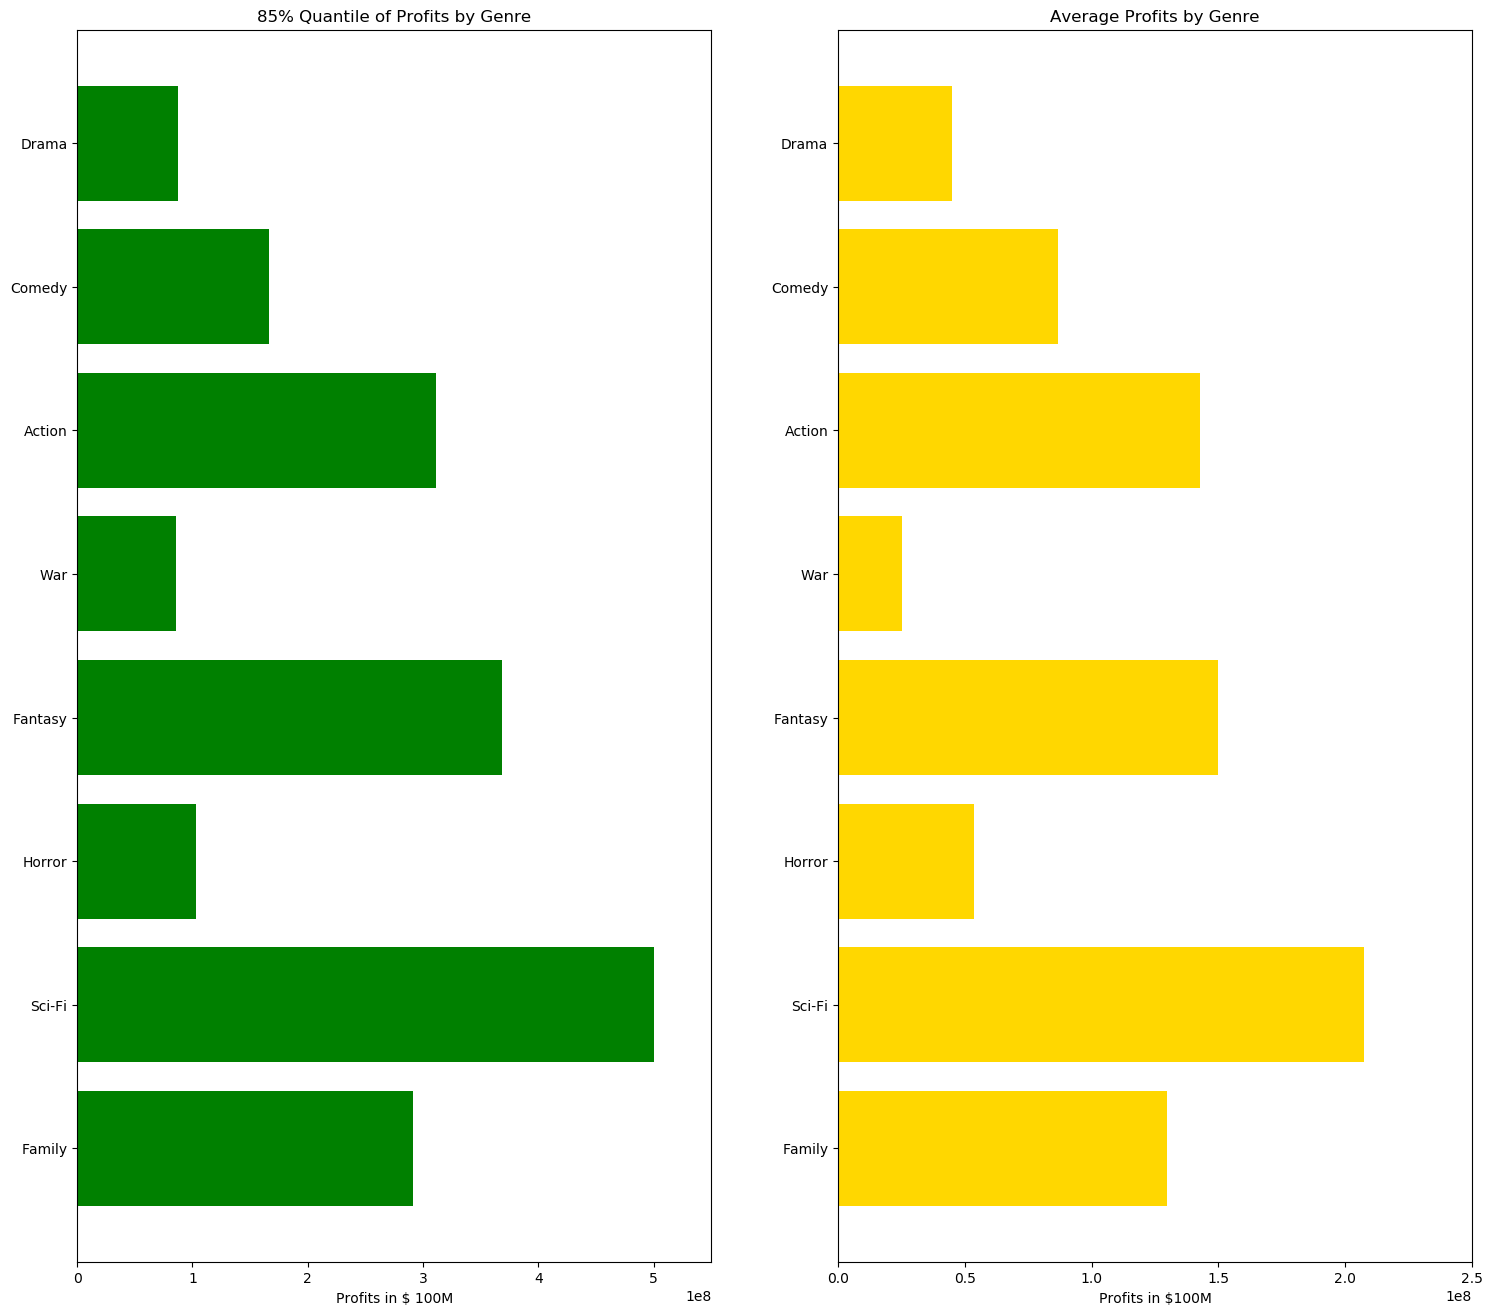

In [185]:
# Create two subplots of the profit by genre data under two metrics
profit_figure = plt.figure(figsize=(18,16))

plt.style.context('dark_background')


# build the subplots
aax = profit_figure.add_subplot(121)
aax2 = profit_figure.add_subplot(122)


# populate first subplot with 85% quantile dat
aaxgenres = ('Drama', 'Comedy', 'Action', 'War', 'Fantasy', 'Horror', 'Sci-Fi', 'Family')
aaxy_pos = np.arange(len(genres))
aaxprofits = (
    dramaprofitsubset_df['profits'].quantile(.85), comedyprofitsubset_df['profits'].quantile(.85), 
    actionprofitsubset_df['profits'].quantile(.85), warprofitsubset_df['profits'].quantile(.85), 
    fantasyprofitsubset_df['profits'].quantile(.85), horrorprofitsubset_df['profits'].quantile(.85), 
    scifiprofitsubset_df['profits'].quantile(.85), familyprofitsubset_df['profits'].quantile(.85)
            )

# setup how the graph is shown
aax.barh(aaxy_pos, aaxprofits, align='center',
        color='green', ecolor='black')
aax.set_yticks(aaxy_pos)
aax.set_yticklabels(aaxgenres)
aax.invert_yaxis()  # labels read top-to-bottom
aax.set_xlim(0, 550000000)
aax.set_xlabel('Profits in $ 100M')
aax.set_title('85% Quantile of Profits by Genre')

#for index, value in enumerate(aaxprofits):
#    plt.text(value, index, str(value))

# populate second subplot with average data
aax2genres = ('Drama', 'Comedy', 'Action', 'War', 'Fantasy', 'Horror', 'Sci-Fi', 'Family')
aax2y_pos = np.arange(len(genres))
aax2profits = (
    np.average(dramaprofitsubset_df['profits']), np.average(comedyprofitsubset_df['profits']), 
    np.average(actionprofitsubset_df['profits']), np.average(warprofitsubset_df['profits']), 
    np.average(fantasyprofitsubset_df['profits']), np.average(horrorprofitsubset_df['profits']), 
    np.average(scifiprofitsubset_df['profits']), np.average(familyprofitsubset_df['profits']), 
            )

# setup how second graph is shown
aax2.barh(aax2y_pos, aax2profits, align='center',
        color='gold', ecolor='black')
aax2.set_yticks(aax2y_pos)
aax2.set_yticklabels(aax2genres)
aax2.invert_yaxis()  # labels read top-to-bottom
aax2.set_xlim(0, 250000000)
aax2.set_xlabel('Profits in $100M')
aax2.set_title('Average Profits by Genre')

#for index, value in enumerate(aax2profits):
#    plt.text(value, index, str(value))
plt.show()

### The code for the graphs below were combined above.
I thought it would be easier to view them side by side to see the impact of taking the 85% quantile, taking out some of the upper and lower outliers which in our context are the huge blockbusters and flops, respectively. This gives us a more objective and realistic look at the data. 

In [142]:
# create a simple bar graph to show 85% quantile of the profits for each Genre
#
#
#fig, ax = plt.subplots()
#
# Build out data to be displayed
#genres = ('Drama', 'Comedy', 'Action', 'War', 'Fantasy', 'Horror', 'Sci-Fi', 'Family')
#y_pos = np.arange(len(genres))
#profits = (
#    np.average(dramaprofitsubset_df['profits']), np.average(comedyprofitsubset_df['profits']), 
#    np.average(actionprofitsubset_df['profits']), np.average(warprofitsubset_df['profits']), 
#    np.average(fantasyprofitsubset_df['profits']), np.average(horrorprofitsubset_df['profits']), 
#    np.average(scifiprofitsubset_df['profits']), np.average(familyprofitsubset_df['profits'])
#            )
#profits = (
#    dramaprofitsubset_df['profits'].quantile(.85), comedyprofitsubset_df['profits'].quantile(.85), 
#    actionprofitsubset_df['profits'].quantile(.85), warprofitsubset_df['profits'].quantile(.85), 
#    fantasyprofitsubset_df['profits'].quantile(.85), horrorprofitsubset_df['profits'].quantile(.85), 
#    scifiprofitsubset_df['profits'].quantile(.85), familyprofitsubset_df['profits'].quantile(.85)
#            )
#
#
#ax.barh(y_pos, profits, align='center',
#        color='green', ecolor='black')
#ax.set_yticks(y_pos)
#ax.set_yticklabels(genres)
#ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xlabel('Profits')
#ax.set_title('85% Quantile of Profits by Genre')
#
#plt.show()

In [143]:
# create a simple bar graph to show average profits for each Genre
#
#plt.rcdefaults()
#fig, ax = plt.subplots()
#
#
# Build out data to be displayed
#genres = ('Drama', 'Comedy', 'Action', 'War', 'Fantasy', 'Horror', 'Sci-Fi', 'Family')
#y_pos = np.arange(len(genres))
#x_pos = np.arange(len(profits))
#profits = (
#    np.average(dramaprofitsubset_df['profits']), np.average(comedyprofitsubset_df['profits']), 
#    np.average(actionprofitsubset_df['profits']), np.average(warprofitsubset_df['profits']), 
#    np.average(fantasyprofitsubset_df['profits']), np.average(horrorprofitsubset_df['profits']), 
#    np.average(scifiprofitsubset_df['profits']), np.average(familyprofitsubset_df['profits'])
#            )
#
#ax.barh(y_pos, profits, align='center',
#        color='gold', ecolor='black')
#ax.set_yticks(y_pos)
#ax.set_yticklabels(genres)
#ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xticks(x_pos)
#ax.set_xlabel('Profits')
#ax.set_title('Average Profits by Genre')
#
#plt.show()

## Working on Directors
Going to look at the most successful directors based off IMDb rating and financials(when available)


In [219]:
newmoviedata_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...",English,USA,Nominated for 7 Oscars. Another 21 wins & 35 n...,80,9.3,tt0111161,movie,0,Columbia Pictures
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay by), Francis Ford Coppo...","English, Italian, Latin",USA,Won 3 Oscars. Another 26 wins & 30 nominations.,100,9.2,tt0068646,movie,0,Paramount Pictures
2,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama, Thriller",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","English, Mandarin","USA, UK",Won 2 Oscars. Another 153 wins & 159 nominations.,84,9.0,tt0468569,movie,"$533,316,061",Warner Bros. Pictures/Legendary
3,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay by), Mario Pu...","English, Italian, Spanish, Latin, Sicilian",USA,Won 6 Oscars. Another 11 wins & 20 nominations.,90,9.0,tt0071562,movie,0,Paramount Pictures
4,The Lord of the Rings: The Return of the King,2003,PG-13,17 Dec 2003,201 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay...","English, Quenya, Old English, Sindarin","New Zealand, USA",Won 11 Oscars. Another 199 wins & 122 nominati...,94,8.9,tt0167260,movie,"$364,000,000",New Line Cinema


In [218]:
print(newmoviedata_df['Director'].value_counts().nlargest(10))
# these are the "most successful" directors going off the metric of 
# success being their number of films in my "top films" database
# I'll be examining their correlation to ratings

Steven Spielberg     14
Martin Scorsese      11
Hayao Miyazaki       10
David Fincher         9
Woody Allen           9
Quentin Tarantino     8
Christopher Nolan     8
Clint Eastwood        8
Rob Reiner            7
Ridley Scott          7
Name: Director, dtype: int64


In [263]:
# create subsets of data for each director I'm looking at
spielberg_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Spielberg', case=False)]
scorsese_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Scorsese', case=False)]
miyazaki_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Miyazaki', case=False)]
fincher_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Fincher', case=False)]
allen_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Woody Allen', case=False)]
tarantino_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Quentin Tarantino', regex=False, case=False)]
nolan_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Christopher Nolan', case=False)]
eastwood_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Eastwood', case=False)]
reiner_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Reiner', case=False)]
scott_df = newmoviedata_df[newmoviedata_df.Director.str.contains('Ridley Scott', case=False)]


In [266]:
tarantino_df

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
5,Pulp Fiction,1994,R,14 Oct 1994,154 min,"Crime, Drama",Quentin Tarantino,"Quentin Tarantino (stories), Roger Avary (stor...","English, Spanish, French",USA,Won 1 Oscar. Another 68 wins & 74 nominations.,94,8.9,tt0110912,movie,0,Miramax Films
61,Django Unchained,2012,R,25 Dec 2012,165 min,"Drama, Western",Quentin Tarantino,Quentin Tarantino,"English, German, French, Italian",USA,Won 2 Oscars. Another 57 wins & 155 nominations.,81,8.4,tt1853728,movie,"$162,804,648",The Weinstein Co.
89,Inglourious Basterds,2009,R,21 Aug 2009,153 min,"Adventure, Drama, War",Quentin Tarantino,Quentin Tarantino,"English, German, French, Italian","Germany, USA",Won 1 Oscar. Another 132 wins & 171 nominations.,69,8.3,tt0361748,movie,"$120,523,073",The Weinstein Company
100,Reservoir Dogs,1992,R,02 Sep 1992,99 min,"Crime, Drama, Thriller",Quentin Tarantino,"Quentin Tarantino, Quentin Tarantino (backgrou...",English,USA,12 wins & 22 nominations.,79,8.3,tt0105236,movie,0,Miramax Films
234,Kill Bill: Vol. 1,2003,R,10 Oct 2003,111 min,"Action, Crime, Thriller",Quentin Tarantino,"Quentin Tarantino, Quentin Tarantino (characte...","English, Japanese, French","USA, Japan",Nominated for 1 Golden Globe. Another 28 wins ...,69,8.1,tt0266697,movie,0,Miramax Films
350,Sin City,2005,R,01 Apr 2005,124 min,"Crime, Thriller","Frank Miller, Robert Rodriguez, Quentin Tarantino",Frank Miller (graphic novels),English,USA,34 wins & 52 nominations.,74,8.0,tt0401792,movie,0,Dimension Films
356,Kill Bill: Vol. 2,2004,R,16 Apr 2004,137 min,"Action, Crime, Thriller",Quentin Tarantino,"Quentin Tarantino, Quentin Tarantino (characte...","English, Cantonese, Mandarin, Spanish",USA,Nominated for 2 Golden Globes. Another 22 wins...,83,8.0,tt0378194,movie,0,Miramax Films
571,The Hateful Eight,2015,R,30 Dec 2015,168 min,"Crime, Drama, Mystery, Thriller, Western",Quentin Tarantino,Quentin Tarantino,"English, Spanish, French",USA,Won 1 Oscar. Another 40 wins & 115 nominations.,68,7.8,tt3460252,movie,"$54,116,191",The Weinstein Company
702,Once Upon a Time... in Hollywood,2019,R,26 Jul 2019,161 min,"Comedy, Drama",Quentin Tarantino,Quentin Tarantino,"English, German, Italian, Spanish","USA, UK, China",Won 2 Oscars. Another 125 wins & 341 nominations.,83,7.7,tt7131622,movie,0,Columbia Pictures


In [278]:
# Removing co-directors from Sin City for ease of modeling
#print(tarantino_df.iat[5,6])
tarantino_df.iat[5,6] = "Quentin Tarantino"
print(tarantino_df.iat[5,6])

Quentin Tarantino


In [279]:
# going to concatenate the individual director subsets to a single, larger df 
# with all the directors I'm working with
directors = [spielberg_df, scorsese_df, miyazaki_df, 
             fincher_df, allen_df, tarantino_df, nolan_df, 
             eastwood_df, reiner_df,scott_df]

directors_df = pd.concat(directors)
directors_df

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
6,Schindler's List,1993,R,04 Feb 1994,195 min,"Biography, Drama, History",Steven Spielberg,"Thomas Keneally (book), Steven Zaillian (scree...","English, Hebrew, German, Polish",USA,Won 7 Oscars. Another 83 wins & 49 nominations.,94,8.9,tt0108052,movie,0,Universal Pictures
23,Saving Private Ryan,1998,R,24 Jul 1998,169 min,"Drama, War",Steven Spielberg,Robert Rodat,"English, French, German, Czech",USA,Won 5 Oscars. Another 74 wins & 74 nominations.,91,8.6,tt0120815,movie,0,Dreamworks Distribution
71,Raiders of the Lost Ark,1981,PG,12 Jun 1981,115 min,"Action, Adventure",Steven Spielberg,"Lawrence Kasdan (screenplay by), George Lucas ...","English, German, Hebrew, Spanish, Arabic, Nepali",USA,Won 4 Oscars. Another 31 wins & 24 nominations.,85,8.4,tt0082971,movie,0,Paramount Pictures
164,Indiana Jones and the Last Crusade,1989,PG-13,24 May 1989,127 min,"Action, Adventure",Steven Spielberg,"Jeffrey Boam (screenplay), George Lucas (story...","English, German, Greek, Arabic",USA,Won 1 Oscar. Another 7 wins & 22 nominations.,65,8.2,tt0097576,movie,0,Paramount Pictures
236,Catch Me If You Can,2002,PG-13,25 Dec 2002,141 min,"Biography, Crime, Drama",Steven Spielberg,"Jeff Nathanson (screenplay), Frank Abagnale Jr...","English, French","USA, Canada",Nominated for 2 Oscars. Another 16 wins & 44 n...,75,8.1,tt0264464,movie,"$164,400,000",DreamWorks SKG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,Blade Runner,1982,R,25 Jun 1982,117 min,"Action, Sci-Fi, Thriller",Ridley Scott,"Hampton Fancher (screenplay), David Webb Peopl...","English, German, Cantonese, Japanese, Hungaria...",USA,Nominated for 2 Oscars. Another 12 wins & 16 n...,84,8.1,tt0083658,movie,0,Warner Bros. Pictures
318,The Martian,2015,PG-13,02 Oct 2015,144 min,"Adventure, Drama, Sci-Fi",Ridley Scott,"Drew Goddard (screenplay by), Andy Weir (based...","English, Mandarin","UK, USA, Hungary, Jordan",Nominated for 7 Oscars. Another 40 wins & 188 ...,80,8.0,tt3659388,movie,"$202,313,768",20th Century Fox
606,American Gangster,2007,R,02 Nov 2007,157 min,"Biography, Crime, Drama, Thriller",Ridley Scott,"Steven Zaillian, Mark Jacobson (article)","English, Thai, Spanish","USA, UK",Nominated for 2 Oscars. Another 13 wins & 35 n...,76,7.8,tt0765429,movie,"$130,127,620",Universal Pictures
770,Black Hawk Down,2001,R,18 Jan 2002,144 min,"Drama, History, War",Ridley Scott,"Mark Bowden (book), Ken Nolan (screenplay)","English, Somali, Arabic","USA, UK",Won 2 Oscars. Another 9 wins & 37 nominations.,74,7.7,tt0265086,movie,"$108,585,355",Sony Pictures


In [296]:
# using locale again to convert BoxOffice to a float
# must convert entire column to string first
directors_df['BoxOffice'] = directors_df['BoxOffice'].astype(str)
locale.setlocale(locale.LC_ALL,'')
directors_df['BoxOffice']=directors_df.BoxOffice.map(lambda x: locale.atof(x.strip('$')))
directors_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Language,Country,Awards,Metascore,imdbRating,imdbID,Type,BoxOffice,Production
6,Schindler's List,1993,R,04 Feb 1994,195 min,"Biography, Drama, History",Steven Spielberg,"Thomas Keneally (book), Steven Zaillian (scree...","English, Hebrew, German, Polish",USA,Won 7 Oscars. Another 83 wins & 49 nominations.,94,8.9,tt0108052,movie,0.0,Universal Pictures
23,Saving Private Ryan,1998,R,24 Jul 1998,169 min,"Drama, War",Steven Spielberg,Robert Rodat,"English, French, German, Czech",USA,Won 5 Oscars. Another 74 wins & 74 nominations.,91,8.6,tt0120815,movie,0.0,Dreamworks Distribution
71,Raiders of the Lost Ark,1981,PG,12 Jun 1981,115 min,"Action, Adventure",Steven Spielberg,"Lawrence Kasdan (screenplay by), George Lucas ...","English, German, Hebrew, Spanish, Arabic, Nepali",USA,Won 4 Oscars. Another 31 wins & 24 nominations.,85,8.4,tt0082971,movie,0.0,Paramount Pictures
164,Indiana Jones and the Last Crusade,1989,PG-13,24 May 1989,127 min,"Action, Adventure",Steven Spielberg,"Jeffrey Boam (screenplay), George Lucas (story...","English, German, Greek, Arabic",USA,Won 1 Oscar. Another 7 wins & 22 nominations.,65,8.2,tt0097576,movie,0.0,Paramount Pictures
236,Catch Me If You Can,2002,PG-13,25 Dec 2002,141 min,"Biography, Crime, Drama",Steven Spielberg,"Jeff Nathanson (screenplay), Frank Abagnale Jr...","English, French","USA, Canada",Nominated for 2 Oscars. Another 16 wins & 44 n...,75,8.1,tt0264464,movie,164400000.0,DreamWorks SKG


Text(0.5, 1.0, 'IMDb Rating by Director')

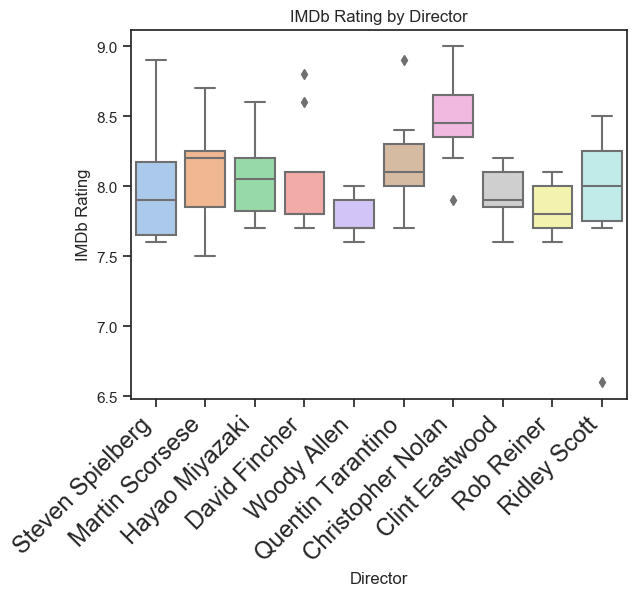

In [315]:
sns.set(style="ticks", palette="pastel")

# Draw a boxplot to show imdbRating by director
dirplot = sns.boxplot(x='Director', y='imdbRating', data=directors_df)

dirplot.set_xticklabels(dirplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');
dirplot.set_ylabel("IMDb Rating")
dirplot.set_title("IMDb Rating by Director")

Text(0.5, 1.0, 'Box Office Gross by Director')

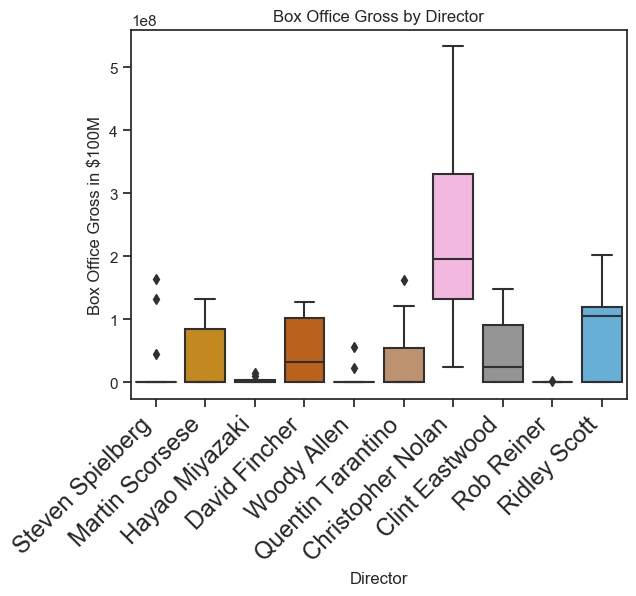

In [313]:
sns.set(style="ticks", palette="colorblind")

dirBoxOffice = sns.boxplot(x='Director', y='BoxOffice', data=directors_df)

dirBoxOffice.set_xticklabels(dirBoxOffice.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');
dirBoxOffice.set_ylabel("Box Office Gross in $100M")
dirBoxOffice.set_title("Box Office Gross by Director")

In [311]:
# Linear regression plot is hard to understand with this data. Will try a standard scatter plot
#sns.set(style='darkgrid')
#
#data = directors_df
#
#lplot = sns.lmplot(x="BoxOffice", y="imdbRating", hue="Director",
#                   data=data)
#
#lplot.set_axis_labels("Box Office in #100M", "IMDb Rating")

Text(0.5, 1.0, 'Relationship Between IMDb Rating and Box Office Success by Director')

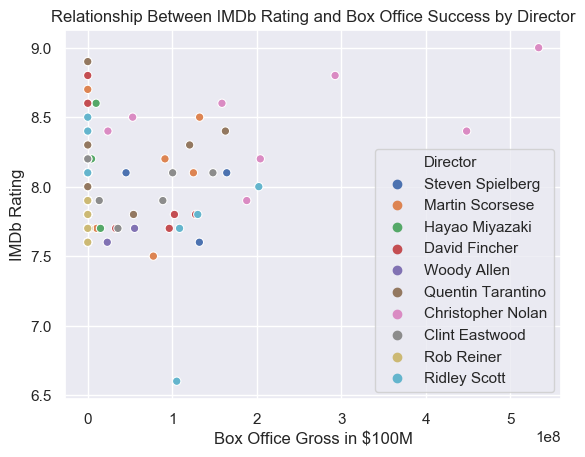

In [310]:
# scatter plot showing relationship between imdb rating and Box Office numbers
sns.set(style='darkgrid')

data = directors_df

scplot = sns.scatterplot(x="BoxOffice", y="imdbRating", hue="Director", data=data)
scplot.set_xlabel("Box Office Gross in $100M")
scplot.set_ylabel("IMDb Rating")
scplot.set_title("Relationship Between IMDb Rating and Box Office Success by Director")

# Visualizing the Genre Data

To more effectively look at the genres effect, I'll create some subsets of the main DF
based off of partial string selections in the Genre column. I can then graph those independantly. 

In [63]:
# The main genres I will break this down to are the following:
# Drama, Comedy, Action, War, Fantasy, Horror, Sci-Fi, Family
dramasubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("Drama")]
comedysubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("Comedy")]
actionsubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("Action")]
warsubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("War")]
fantasysubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("Fantasy")]
horrorsubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("Horror")]
scifisubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("Sci-Fi")]
familysubset_df = newmoviedata_df[newmoviedata_df['Genre'].str.contains("Family")]
# Created subsets of the main DF based off their Genre

In [64]:
import seaborn as sns

C:\Users\Ryans\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Ryans\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


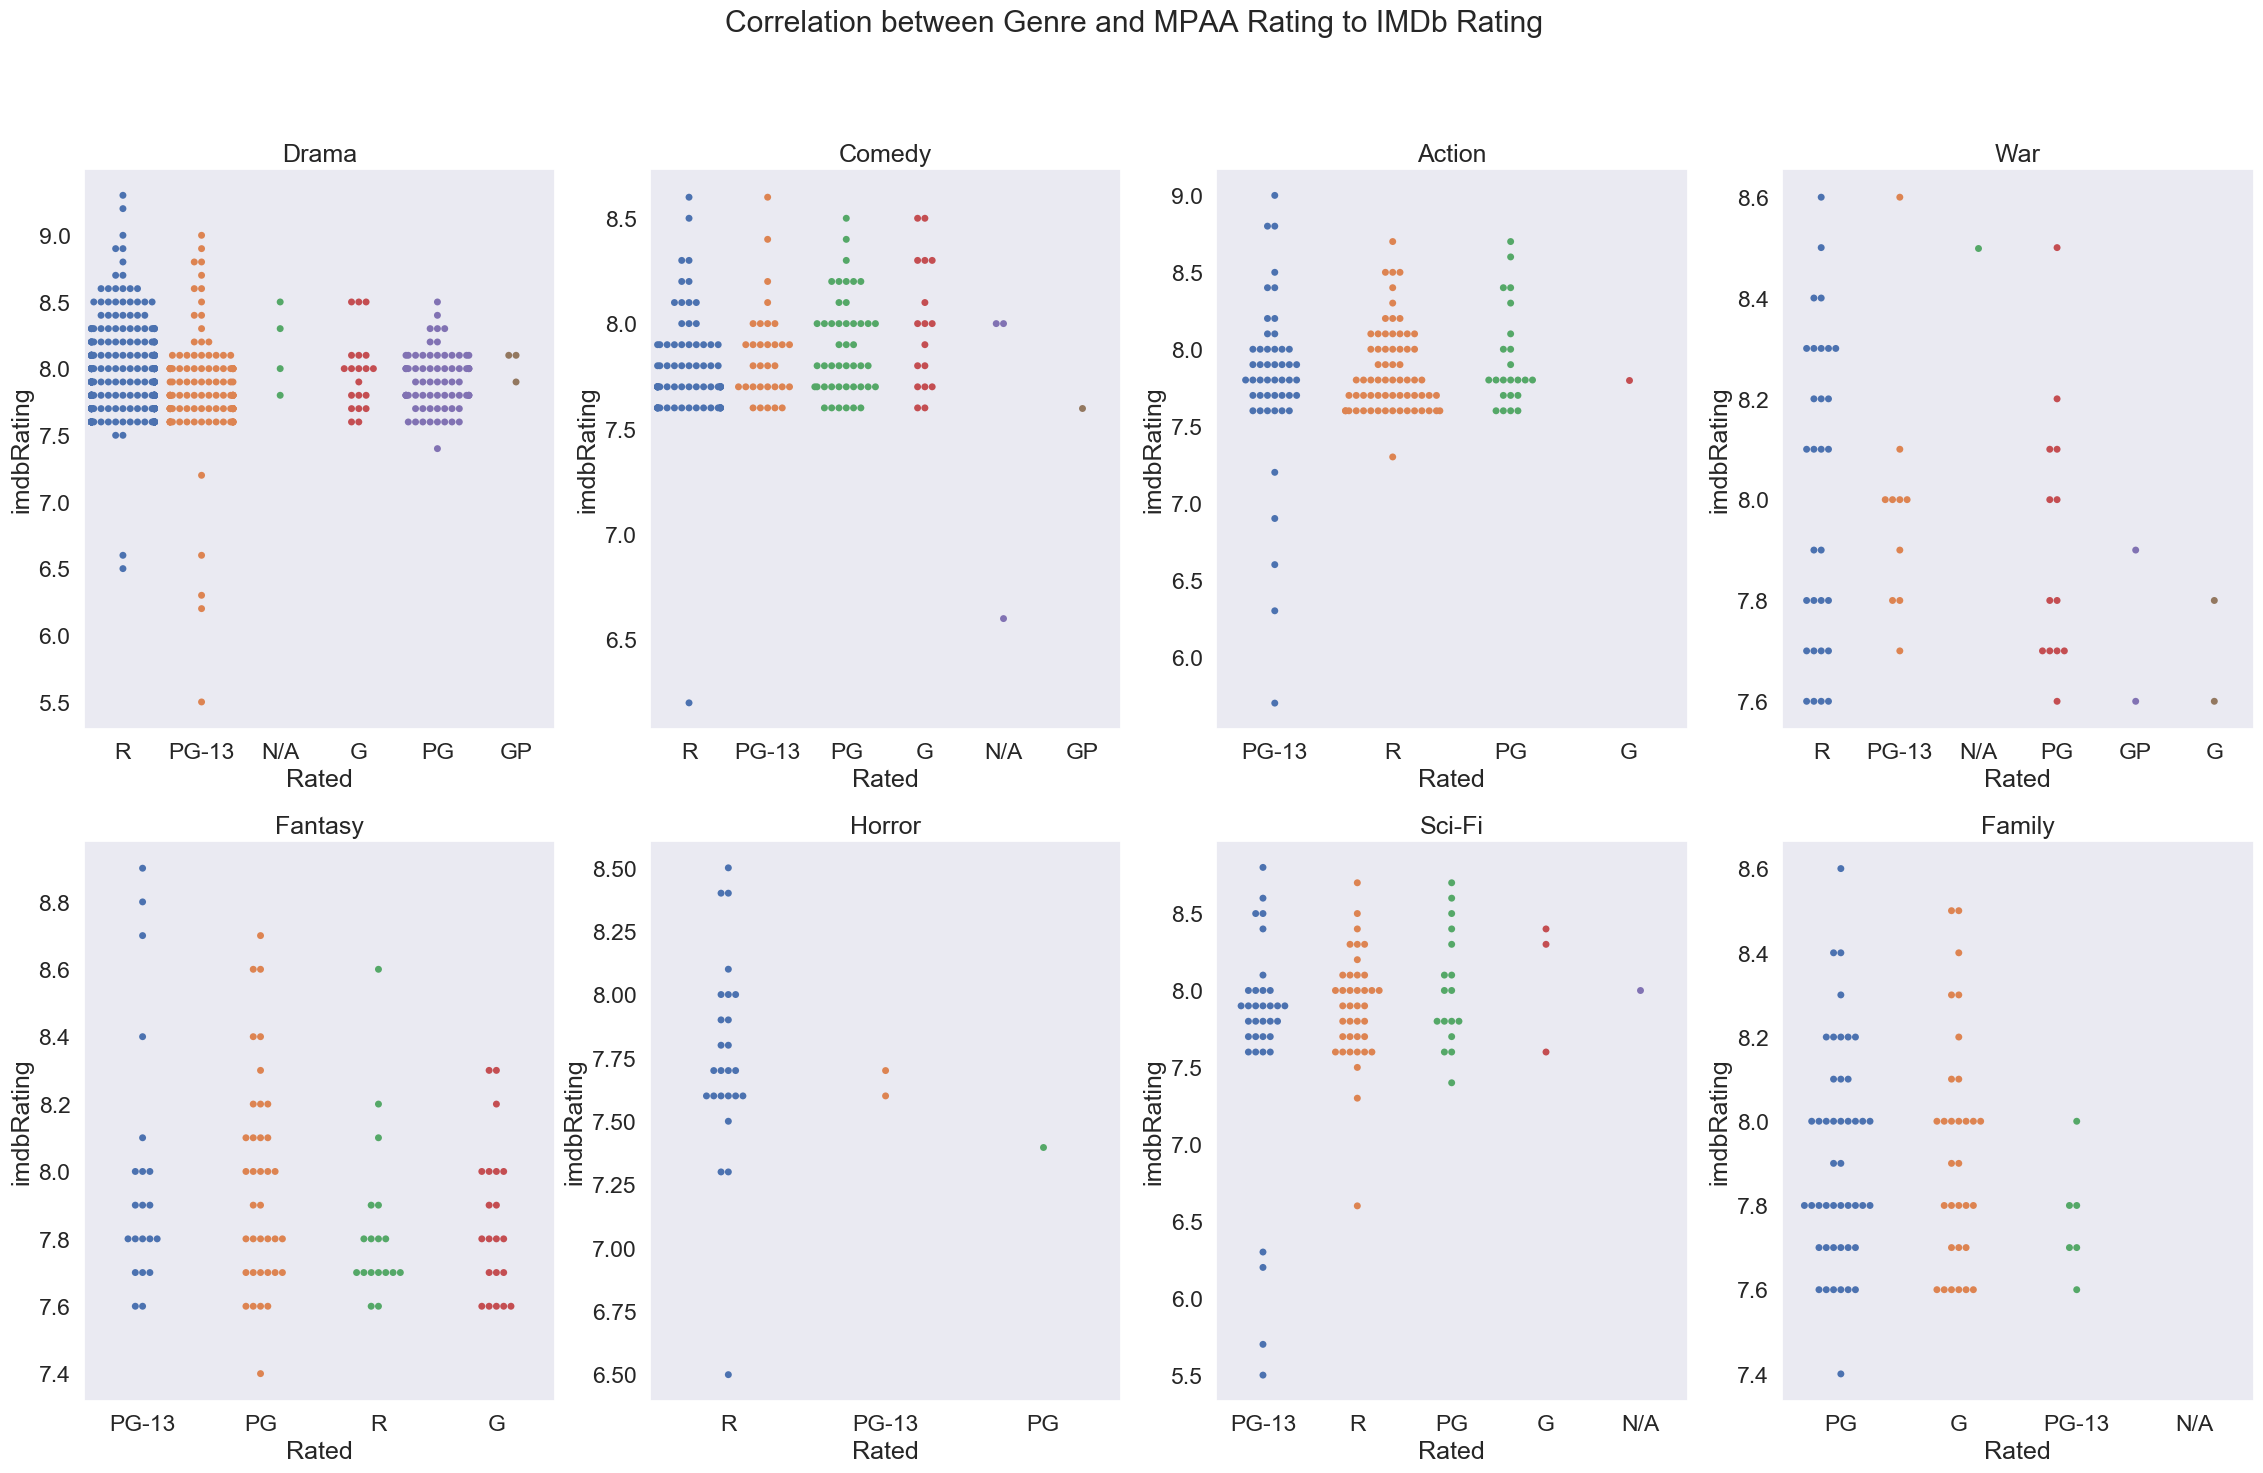

In [338]:
new_figure = plt.figure(figsize=(28,16))
sns.set(style="dark", font_scale=1.5)
sns.color_palette("RdBu", n_colors=7)
new_figure.tight_layout(pad=10.0)

#subplot for Drama
ax1 = new_figure.add_subplot(241)
ax1.set_title('Drama')
sns.swarmplot(dramasubset_df['Rated'], dramasubset_df['imdbRating'])

#subplot for Comedy
ax2 = new_figure.add_subplot(242)
ax2.set_title('Comedy')
sns.swarmplot(comedysubset_df['Rated'], comedysubset_df['imdbRating'])

#subplot for Action
ax3 = new_figure.add_subplot(243)
ax3.set_title('Action')
sns.swarmplot(actionsubset_df['Rated'], actionsubset_df['imdbRating'])

#subplot for War
ax4 = new_figure.add_subplot(244)
ax4.set_title('War')
sns.swarmplot(warsubset_df['Rated'], warsubset_df['imdbRating'])

#subplot for Fantasy
ax5 = new_figure.add_subplot(245)
ax5.set_title('Fantasy')
sns.swarmplot(fantasysubset_df['Rated'], fantasysubset_df['imdbRating'])

#subplot for Horror
ax6 = new_figure.add_subplot(246)
ax6.set_title('Horror')
sns.swarmplot(horrorsubset_df['Rated'], horrorsubset_df['imdbRating'])

#subplot for Sci-fi
ax7 = new_figure.add_subplot(247)
ax7.set_title('Sci-Fi')
sns.swarmplot(scifisubset_df['Rated'], scifisubset_df['imdbRating'])

#subplot for Family
ax8 = new_figure.add_subplot(248)
ax8.set_title('Family')
sns.swarmplot(familysubset_df['Rated'], familysubset_df['imdbRating'])

plt.suptitle('Correlation between Genre and MPAA Rating to IMDb Rating')
plt.subplots_adjust(wspace=0.2)

In [330]:
# convert metascore data to integer
dramasubset_df['Metascore'] = pd.to_numeric(dramasubset_df['Metascore'], errors='coerce')
dramasubset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543 entries, 0 to 999
Data columns (total 17 columns):
Title         543 non-null object
Year          543 non-null object
Rated         543 non-null object
Released      543 non-null object
Runtime       543 non-null object
Genre         543 non-null object
Director      543 non-null object
Writer        543 non-null object
Language      543 non-null object
Country       543 non-null object
Awards        543 non-null object
Metascore     515 non-null float64
imdbRating    543 non-null float64
imdbID        543 non-null object
Type          543 non-null object
BoxOffice     543 non-null object
Production    543 non-null object
dtypes: float64(2), object(15)
memory usage: 96.4+ KB


C:\Users\Ryans\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [333]:
# convert the metascore data to integer
comedysubset_df['Metascore'] = pd.to_numeric(comedysubset_df['Metascore'], errors='coerce')
actionsubset_df['Metascore'] = pd.to_numeric(actionsubset_df['Metascore'], errors='coerce')

C:\Users\Ryans\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ryans\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Drama')

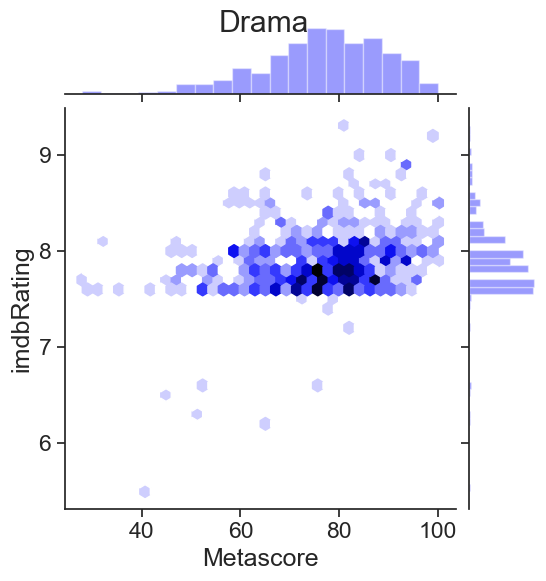

In [364]:
# try out a hexbin for the highest rated genres; Drama, Comedy, and Action

#subplot for Drama
aax = sns.jointplot(dramasubset_df['Metascore'], dramasubset_df['imdbRating'], kind="hex", color="#0307fc")
aax.fig.suptitle("Drama")


Text(0.5, 0.98, 'Comedy')

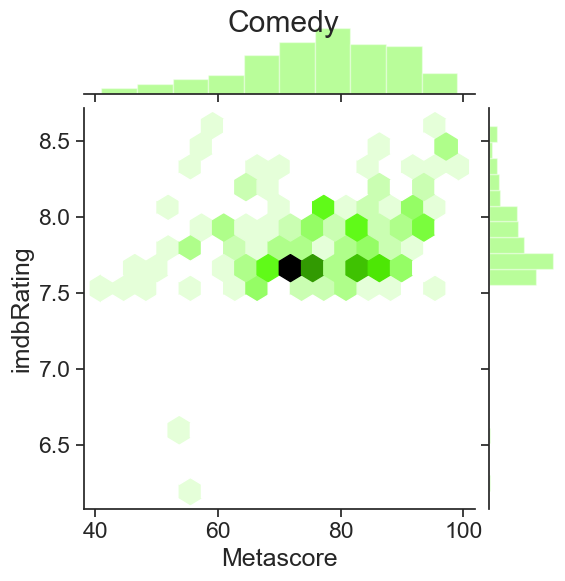

In [365]:
#subplot for Comedy
aax1 = sns.jointplot(comedysubset_df['Metascore'], comedysubset_df['imdbRating'], kind="hex", color="#52fc03")
aax1.fig.suptitle("Comedy")

Text(0.5, 0.98, 'Action')

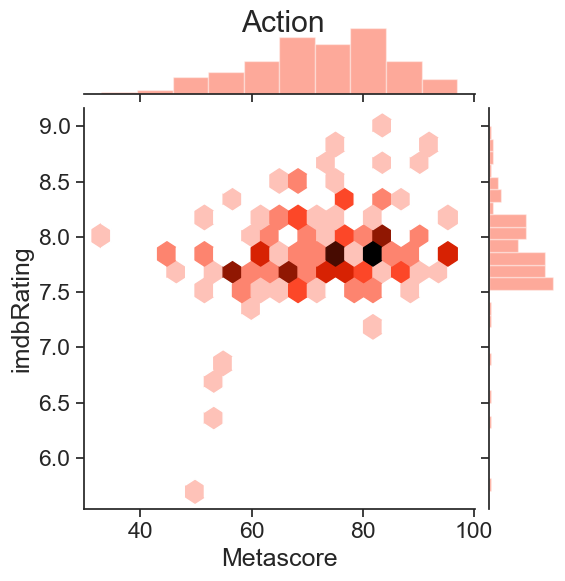

In [366]:
#subplot for Action
aax2 = sns.jointplot(actionsubset_df['Metascore'], actionsubset_df['imdbRating'], kind="hex", color="#fc2803")
aax2.fig.suptitle("Action")